In [2]:
library(brms)
library(tidyverse)
library(parallel)

# Model description

In addition to ROI level analysis, BML was applied to non-smoothed voxel level data of insula and amygdala separately to investigate responses to threat and safe at a finer resolution. ROI masks utilized in ROI-level analysis were further subdivided into smaller sub-regions (sub-ROIs) using k-means clustering based on the coordinates of voxels.

***Insula.*** 941 voxels of left insula were clustered into 11 sub-ROIs and 986 voxels of right insula were clustered into 10 sub-ROIs. Due to the limitation of computational power and potential time cost, BMLs were applied to the left and right insula separately without considering STAI scores.

Similar to BML of ROI level analysis, two different time windows from block onset were considered: early (2.50 – 8.75 s) and late (10.00-16.25 s) phase. Then, the same summarizing strategy was applied to time series from first level model described above as following:

For $s$th subject’s voxel $v$ in ROI $r$ on hemisphere $h$ at phase $p$ of insula and amygdala, the difference between responses to safe and threat is:

$$
\begin{aligned}
\Delta_{s,h,r,v} & = \sum_{t}^{t \in p}(y_{s,h,r,v,t,\text{threat}} -m_{s,h,r,v,t}) -\sum_{t}^{t \in p}(y_{s,h,r,v,t,\text{safe}} -m_{s,h,r,v,t}) \\& = \sum_{t}^{t \in p}(y_{s,h,r,v,t,\text{threat}} -y_{s,h,r,v,t,\text{safe}})
\end{aligned}
$$

Where,

$$
m_{s,h,r,v,t} = \underset{\text{safe, threat}}{\mathrm{Min}}\{y_{s,h,r,v,t,\text{safe}}, y_{s,h,r,v,t,\text{threat}}\}
$$

The model for given time window $p$ and hemisphere $h$ for insula then can be expressed in terms of a linear mixed effect model notation (lme-like) as:

$$
\Delta_{s,h,r,v} \sim 1 + (1|\text{Sub}) + (1|\text{ROI}) + (1|\text{VOX})
$$

Based on the distribution of summarized-estimated activation, the full model in the notation of \citet{mcelreath2018statistical} is:

$$
\Delta_{s,h,r,v} \sim \text{Student t}(\nu, \mu_{s,h,r,v},\sigma^{2})
$$

and,

$$
\mu_{s,h,r,v} = \alpha + \alpha_{\text{subj}[s]} + \alpha_{\text{roi}[r]} + \alpha_{\text{voxel}[v]}
$$

where,

$$
\alpha_{j} \sim \text{student} (\nu_{j}, 0, \sigma_{j}^2), \quad j \in \{\text{subj, roi, voxel}\}
$$

***Priors*** The priors were defined similar to BML of ROI-level analysis expect for all degrees of freedom. The shortage of data in a group of ROI or voxel among subjects required more iterations in MCMC or more informative priors of these parameters, which was also suggested by the simulations based on the current dataset. Therefore, the priors were employed as:

$$\alpha \sim \text{Student t}(3, \mu_{y}, 2.5)$$
$$\nu \sim \text{Gamma}(3.325, 0.5)$$
$$\nu_{j} \sim \text{Gamma}(3.325, 0.5)$$
$$\sigma \sim \text{Half Student}(3, 0, 2.5)$$
$$\sigma_{j} \sim \text{Half Student}(3, 0, 2.5)$$
notice that $\mu_{y}$ is the sample mean of $\Delta_{s,h,r,v}$

Similarly, posterior distribution of the effect of trial is given by:

$$
p_{\text{trial}, [i,h,r,v]} = p_{\alpha, [i]} + \sum_j^{j \in \mathbb{V}}p_{\alpha_{j, [i]}}
$$

where,
* $\mathbb{V} =\{\text{roi}[r], \text{voxel}[v]\}$
* $p_{\alpha, [i]}$: posterior sample of fixed intercept $\alpha$ at $i$th iteration
* $p_{\alpha_{j, [i]}}$: posterior sample of random intercept $j \in \mathbb{V}$ at $i$th iteration

And the $P+$ values were obtained as the same with ROI-level analysis.

# Extract posteriors

In [3]:
# Load the BML output (.RData)
# For insula, there are 4 models: left_early, left_late, right_early, right_late
# Please select desired model by assign following variables
# hem: left or right
# phase: early or late

hem <- 'left'
phase <- 'early'

respath <- paste0('results_offset/insula_', hem, '_', phase, "/")

load(paste0(respath, "insula_", hem, "_", phase, ".RData"))

In [4]:
ls()

[1] "chains"     "dataTable"  "df"         "fm"         "hem"       
 [6] "iterations" "mod"        "modelForm"  "nfigs"      "ns"        
[11] "phase"      "priorRBA"   "project"    "respath"    "SCALE"     
[16] "stan_code"

In [5]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

In [6]:
write.table(as.data.frame(aa), file=paste0(respath, '/POP.txt'), sep='\t',
            col.names = TRUE, row.names = FALSE)

In [7]:
for (col in colnames(aa)){
    if (col == "Intercept"){
        roi_eff <- data.frame(bb[['ROI']][,,col])
        write.table(roi_eff, paste0(respath,'/ROI_',col,'.txt'), sep='\t',
                    col.names = TRUE, row.names = FALSE)
        
        vox_eff <- data.frame(bb[['VOX']][,,col])
        write.table(vox_eff, paste0(respath,'/VOX_',col,'.txt'), sep='\t',
                    col.names = TRUE, row.names = FALSE)
    }
}

In [9]:
# Shows the summary of the model
cat(capture.output(summary(fm)), sep = '\n', append = TRUE)

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above  may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: diff ~ 1 + (1 | gr(Subj, dist = "student")) + (1 | gr(ROI, dist = "student")) + (1 | gr(VOX, dist = "student")) 
   Data: dataTable (Number of observations: 102450) 
Samples: 4 chains, each with iter = 20000; warmup = 10000; thin = 1;
         total post-warmup samples = 40000

Group-Level Effects: 
~ROI (Number of levels: 11) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
df                7.41      3.67     2.23    16.32 1.00     4240     5936
sd(Intercept)     0.21      0.06     0.12     0.36 1.00     7926    11961

~Subj (Number of levels: 109) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
df                6.69      2.84     2.92    13.87 1.01      586     1462
sd(Intercept)     0.70      0.07     0.56     0.84 1.00     1200     2506

~VOX (Number of levels: 940) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
df   

# Diagnosis

Warning message:
“Removed 1156333 rows containing non-finite values (stat_density).”
Warning message:
“Removed 1825 rows containing non-finite values (stat_density).”


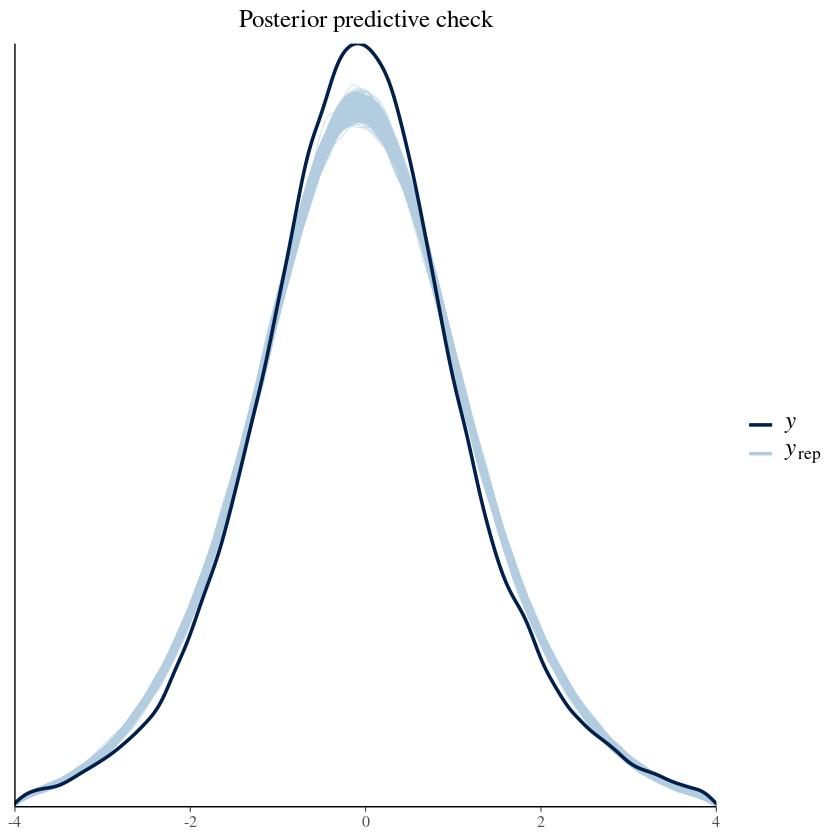

In [4]:
# Posterior predictive check
pp_check(fm, nsamples = 1000) + 
    xlim(c(-4, 4)) + 
    theme(plot.title = element_text(size = 15, hjust = 0.5), 
          legend.text = element_text(size = 15)) + 
    ggtitle("Posterior predictive check")